# Sigma Sweep: Can Lattice Coarsening Produce Black Holes?

**Hypothesis:** Tokens initialized near the origin (where bfloat16 resolution is fine) could coalesce into black holes when translated to R ≈ 0.37 (where resolution is coarser).

**Experiment:** For various initial spread σ:
1. Generate 151,936 points from N(0, σ) in 2560D
2. Translate by John's exact bfloat16 coordinates (the 814-token black hole)
3. Quantize to bfloat16
4. Randomly select 2,200 "survivors" (simulating dead tokens)
5. Count unique vectors among survivors

**Question:** Is there a σ that produces the coalescence pattern we see in Qwen 3 4B?

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from tqdm import tqdm

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

# Parameters
RANDOM_SEED = 42
N_TOKENS = 151936
N_SURVIVORS = 2200
D = 2560

# Sigma sweep: integer exponents from -10 to -2
SIGMAS = [10**exp for exp in range(-10, -1)]  # 1e-10 through 1e-2

print(f"Sigmas to test: {SIGMAS}")

Using device: mps
Sigmas to test: [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01]


In [2]:
# Load John: the 814-token black hole at token index 80091
DATA_DIR = Path("../../../tensors/Qwen3-4B-Instruct-2507")
W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)

john_bf16 = W[80091]  # The One True Offset Vector
john_f32 = john_bf16.float()

print(f"John's coordinates loaded: {john_bf16.shape}, dtype={john_bf16.dtype}")
print(f"John's L2 norm: {torch.norm(john_f32).item():.6f}")

John's coordinates loaded: torch.Size([2560]), dtype=torch.bfloat16
John's L2 norm: 0.370917


## The Experiment

For each σ, we:
1. Generate N(0, σ) noise in float32
2. Add John (in float32)
3. Quantize to bfloat16
4. Sample 2,200 survivors uniformly at random
5. Count unique bfloat16 vectors among survivors

In [3]:
def run_experiment(sigma, john_f32, n_tokens, n_survivors, d, seed):
    """
    Run one sigma experiment.
    
    Returns:
        n_unique: number of unique bfloat16 vectors among survivors
        black_hole_sizes: sorted list of counts for vectors with >1 token
    """
    torch.manual_seed(seed)
    
    # Step 1: Generate N(0, σ) noise
    noise = torch.randn(n_tokens, d, dtype=torch.float32) * sigma
    
    # Step 2: Translate by John
    translated = noise + john_f32.unsqueeze(0)
    
    # Step 3: Quantize to bfloat16
    quantized = translated.to(torch.bfloat16)
    
    # Step 4: Random survivor selection
    perm = torch.randperm(n_tokens)[:n_survivors]
    survivors = quantized[perm]
    
    # Step 5: Count unique vectors
    survivors_bits = survivors.view(torch.uint16).to(torch.int32)
    unique_bits, inverse, counts = torch.unique(
        survivors_bits, dim=0, return_inverse=True, return_counts=True
    )
    
    n_unique = len(unique_bits)
    
    # Black hole analysis
    black_hole_mask = counts > 1
    black_hole_sizes = sorted(counts[black_hole_mask].tolist(), reverse=True)
    
    return n_unique, black_hole_sizes

In [4]:
# Run the sweep
results = []

for sigma in tqdm(SIGMAS, desc="Sigma sweep"):
    n_unique, bh_sizes = run_experiment(
        sigma=sigma,
        john_f32=john_f32,
        n_tokens=N_TOKENS,
        n_survivors=N_SURVIVORS,
        d=D,
        seed=RANDOM_SEED
    )
    
    n_black_holes = len(bh_sizes)
    largest_bh = bh_sizes[0] if bh_sizes else 0
    tokens_in_bh = sum(bh_sizes)
    
    results.append({
        'sigma': sigma,
        'n_unique': n_unique,
        'n_black_holes': n_black_holes,
        'largest_bh': largest_bh,
        'tokens_in_bh': tokens_in_bh,
        'bh_sizes': bh_sizes
    })
    
    print(f"σ = {sigma:.0e}: {n_unique:,} unique, {n_black_holes} black holes, largest = {largest_bh}")

Sigma sweep:   0%|          | 0/9 [00:00<?, ?it/s]

Sigma sweep:  11%|█         | 1/9 [00:02<00:20,  2.62s/it]

σ = 1e-10: 1 unique, 1 black holes, largest = 2200


Sigma sweep:  22%|██▏       | 2/9 [00:05<00:18,  2.59s/it]

σ = 1e-09: 1 unique, 1 black holes, largest = 2200


Sigma sweep:  33%|███▎      | 3/9 [00:07<00:15,  2.59s/it]

σ = 1e-08: 210 unique, 146 black holes, largest = 88


Sigma sweep:  44%|████▍     | 4/9 [00:10<00:12,  2.59s/it]

σ = 1e-07: 2,200 unique, 0 black holes, largest = 0


Sigma sweep:  56%|█████▌    | 5/9 [00:12<00:10,  2.59s/it]

σ = 1e-06: 2,200 unique, 0 black holes, largest = 0


Sigma sweep:  67%|██████▋   | 6/9 [00:15<00:07,  2.59s/it]

σ = 1e-05: 2,200 unique, 0 black holes, largest = 0


Sigma sweep:  78%|███████▊  | 7/9 [00:18<00:05,  2.60s/it]

σ = 1e-04: 2,200 unique, 0 black holes, largest = 0


Sigma sweep:  89%|████████▉ | 8/9 [00:20<00:02,  2.62s/it]

σ = 1e-03: 2,200 unique, 0 black holes, largest = 0


Sigma sweep: 100%|██████████| 9/9 [00:23<00:00,  2.62s/it]

Sigma sweep: 100%|██████████| 9/9 [00:23<00:00,  2.60s/it]

σ = 1e-02: 2,200 unique, 0 black holes, largest = 0


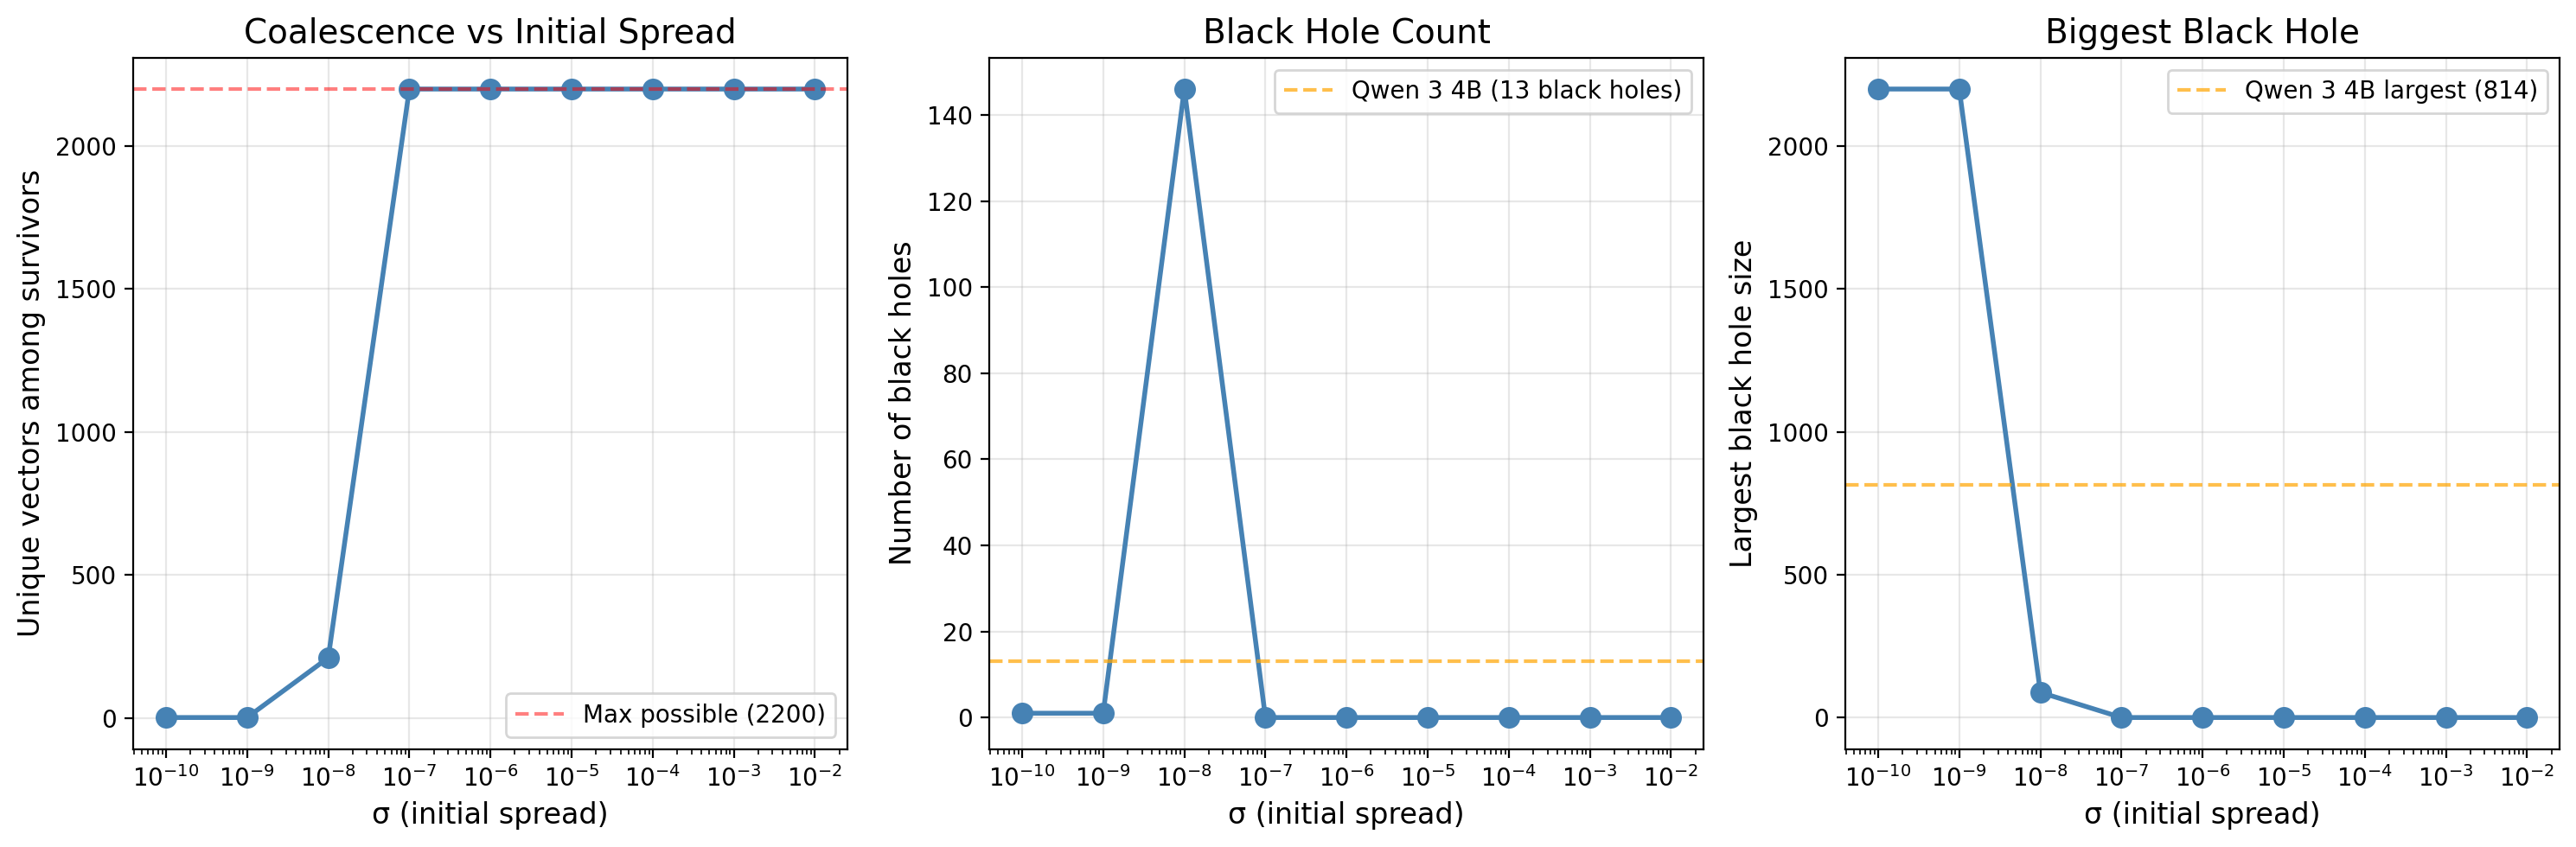

In [5]:
# Plot: Unique vectors vs sigma
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

sigmas = [r['sigma'] for r in results]
n_uniques = [r['n_unique'] for r in results]
n_bhs = [r['n_black_holes'] for r in results]
largest_bhs = [r['largest_bh'] for r in results]

# Panel 1: Unique vectors
ax = axes[0]
ax.semilogx(sigmas, n_uniques, 'o-', color='steelblue', linewidth=2, markersize=8)
ax.axhline(N_SURVIVORS, color='red', linestyle='--', alpha=0.5, label=f'Max possible ({N_SURVIVORS})')
ax.set_xlabel('σ (initial spread)', fontsize=12)
ax.set_ylabel('Unique vectors among survivors', fontsize=12)
ax.set_title('Coalescence vs Initial Spread', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Number of black holes
ax = axes[1]
ax.semilogx(sigmas, n_bhs, 'o-', color='steelblue', linewidth=2, markersize=8)
ax.axhline(13, color='orange', linestyle='--', alpha=0.7, label='Qwen 3 4B (13 black holes)')
ax.set_xlabel('σ (initial spread)', fontsize=12)
ax.set_ylabel('Number of black holes', fontsize=12)
ax.set_title('Black Hole Count', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Largest black hole
ax = axes[2]
ax.semilogx(sigmas, largest_bhs, 'o-', color='steelblue', linewidth=2, markersize=8)
ax.axhline(814, color='orange', linestyle='--', alpha=0.7, label='Qwen 3 4B largest (814)')
ax.set_xlabel('σ (initial spread)', fontsize=12)
ax.set_ylabel('Largest black hole size', fontsize=12)
ax.set_title('Biggest Black Hole', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Detailed output: show black hole distributions for interesting sigmas
print("Black hole size distributions:")
print("=" * 60)
print(f"{'σ':<12} {'Unique':<8} {'# BH':<6} {'Sizes (up to 10)'}")
print("-" * 60)

for r in results:
    sizes_str = str(r['bh_sizes'][:10])
    if len(r['bh_sizes']) > 10:
        sizes_str = sizes_str[:-1] + ', ...]'
    print(f"{r['sigma']:<12.0e} {r['n_unique']:<8} {r['n_black_holes']:<6} {sizes_str}")

print("\n" + "=" * 60)
print("Qwen 3 4B reference: 13 black holes, sizes [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]")

Black hole size distributions:
σ            Unique   # BH   Sizes (up to 10)
------------------------------------------------------------
1e-10        1        1      [2200]
1e-09        1        1      [2200]
1e-08        210      146    [88, 78, 76, 76, 71, 66, 65, 56, 54, 46, ...]
1e-07        2200     0      []
1e-06        2200     0      []
1e-05        2200     0      []
1e-04        2200     0      []
1e-03        2200     0      []
1e-02        2200     0      []

Qwen 3 4B reference: 13 black holes, sizes [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]


## Analysis

What we're looking for:
- **Total coalescence (σ too small):** All 2,200 tokens collapse into 1 or a few vectors
- **No coalescence (σ too large):** ~2,200 unique vectors, no black holes
- **Phase transition zone:** Partial coalescence, black holes form

Does any σ produce something that *looks like* Qwen 3 4B's pattern?
- 13 black holes
- Largest ~800 tokens
- Heavy tail distribution